In [1]:
import os
import glob
import random
import re
import pickle
import gc

import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras

import tqdm

import cv2

import tensorflow as tf

from tensorflow.keras import layers, models, callbacks
from tensorflow.image import resize_with_pad

from tensorflow.keras.preprocessing.image import (
    load_img, 
    img_to_array, 
    ImageDataGenerator,
    array_to_img,
    save_img
)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
TARGET_HEIGHT = 224
TARGET_WIDTH = 224

# ===================

# This is where the NN modelling will go
## For NN modelling I will use the train-val-test set obtained from splitfolders 

In [4]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
)

In [5]:
#batch_size = 256

train_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/train',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 64,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

val_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/val',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 64,
    class_mode = 'categorical',
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

test_gen = datagen.flow_from_directory(
    'C:/temp_workfolder/rbc_keras/keras_split/test',
    target_size = (TARGET_HEIGHT, TARGET_WIDTH),
    batch_size = 64,
    class_mode = 'categorical',   #'categorical'
    interpolation='nearest',
    seed = 42,
    shuffle = True
)

Found 4261 images belonging to 9 classes.
Found 1418 images belonging to 9 classes.
Found 1429 images belonging to 9 classes.


In [19]:
train_gen.class_indices

{'acantocyte': 0,
 'elliptocyte': 1,
 'hypochromic': 2,
 'normal': 3,
 'pencil': 4,
 'spero_bulat': 5,
 'stomatocyte': 6,
 'targetsel': 7,
 'teardrop': 8}

In [20]:
#train_gen.filenames[1000:1010]

In [6]:
X_train, Y_train = next(train_gen)
print(X_train.shape)
print(Y_train.shape)

(64, 224, 224, 3)
(64, 9)


In [7]:
X_val, Y_val = next(val_gen)
print(X_val.shape)
print(Y_val.shape)

(64, 224, 224, 3)
(64, 9)


In [8]:
X_test, Y_test = next(test_gen)
print(X_test.shape)
print(Y_test.shape)

(64, 224, 224, 3)
(64, 9)


In [16]:
resnet_model = ResNet50(weights=None, classes=9, include_top=True)#, input_shape=(96, 96, 3))
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
print(resnet_model.summary())
gc.collect()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

33380

In [18]:
gc.collect()

0

In [88]:
res_img_path = 'C:/temp_workfolder/rbc_keras/keras_split/test/elliptocyte/T3-K1-0049 objek#27.png'
res_img = load_img(res_img_path, target_size=(224, 224))
res_x = img_to_array(res_img)
res_x = np.expand_dims(res_x, axis=0)
res_x = preprocess_input(res_x)

res_pred = resnet_model.predict(res_x)

print('Predicted:', decode_predictions(res_pred, top=3)[0])

Predicted: [('n01930112', 'nematode', 0.2494993), ('n02317335', 'starfish', 0.23845997), ('n02321529', 'sea_cucumber', 0.19629721)]


In [63]:
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
inception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_188 (Conv2D)            (None, 47, 47, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 47, 47, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_188 (Activation)    (None, 47, 47, 32)   0           ['batch_normalization_

In [25]:
vgg16_model = VGG16(include_top=True,
                    #input_shape=(TARGET_HEIGHT,TARGET_WIDTH,3),
                    weights=None,
                    classes=9)
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
gc.collect()
vgg16_model.summary()
gc.collect()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

1333

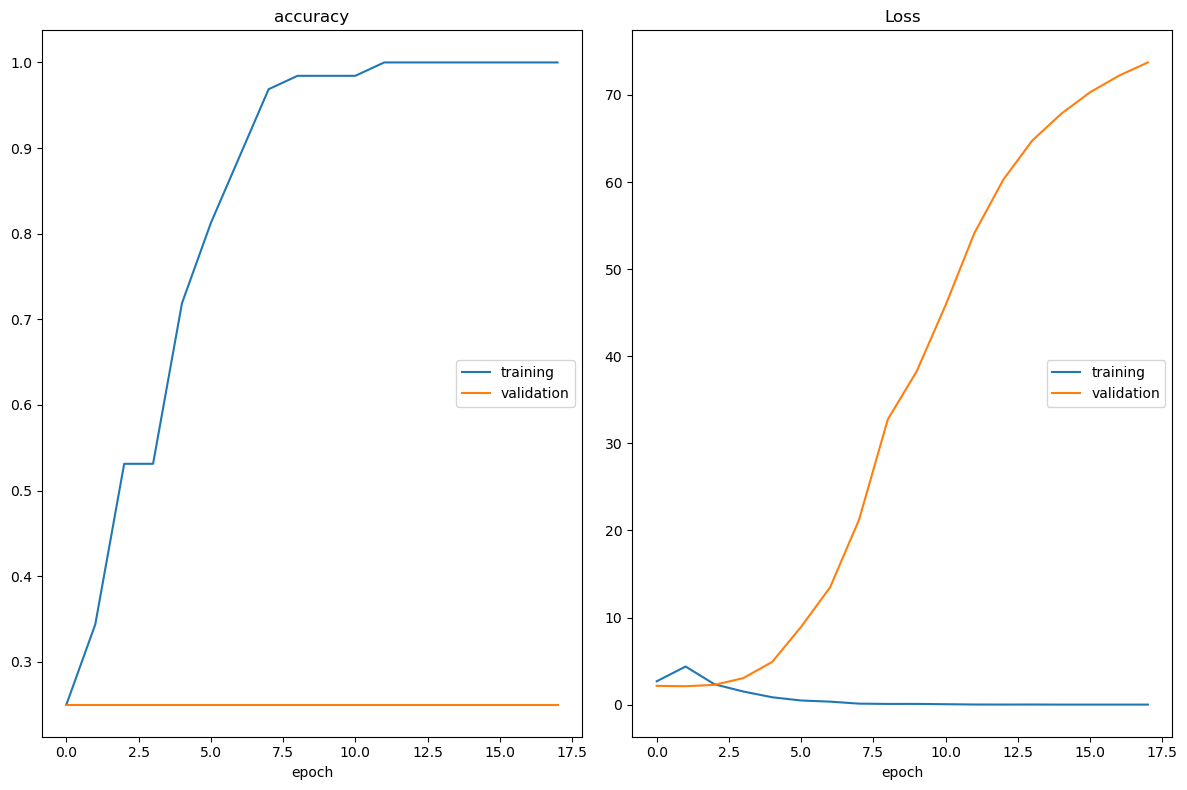

accuracy
	training         	 (min:    0.250, max:    1.000, cur:    1.000)
	validation       	 (min:    0.250, max:    0.250, cur:    0.250)
Loss
	training         	 (min:    0.002, max:    4.376, cur:    0.003)
	validation       	 (min:    2.114, max:   73.727, cur:   73.727)
2/2 [==============================] - 1s 707ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 73.7268 - val_accuracy: 0.2500


97760

In [19]:

resnet_model.fit(X_train,
               Y_train,
               epochs=100,
               #steps_per_epoch=32,
               validation_data=(X_val,Y_val),
               validation_freq=1,
               callbacks=[EarlyStopping(patience=16, verbose=0),PlotLossesKeras()]
              )
gc.collect()


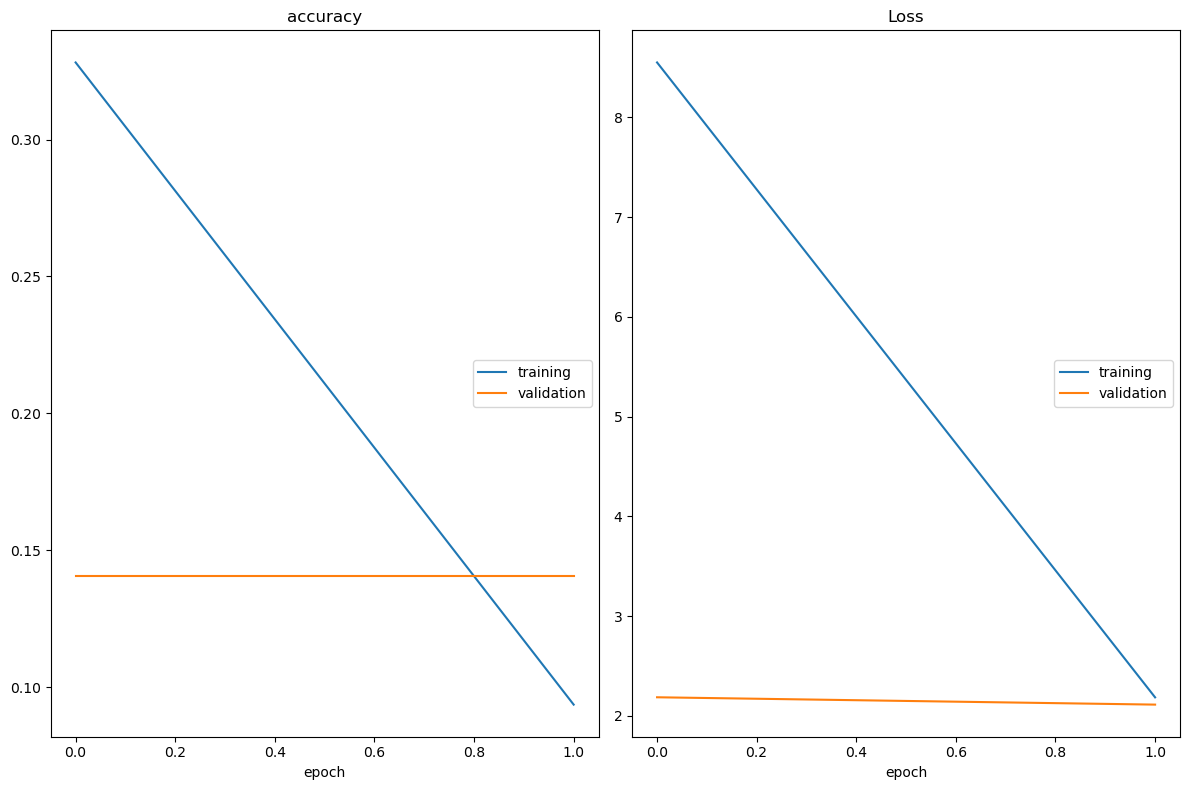

accuracy
	training         	 (min:    0.094, max:    0.328, cur:    0.094)
	validation       	 (min:    0.141, max:    0.141, cur:    0.141)
Loss
	training         	 (min:    2.186, max:    8.551, cur:    2.186)
	validation       	 (min:    2.113, max:    2.187, cur:    2.113)
2/2 [==============================] - 1s 594ms/step - loss: 2.1858 - accuracy: 0.0938 - val_loss: 2.1131 - val_accuracy: 0.1406
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 2.1250 - accuracy: 0.0312

InternalError: Could not synchronize CUDA stream: CUDA_ERROR_LAUNCH_TIMEOUT: the launch timed out and was terminated

In [26]:
vgg16_model.fit(X_train,
               Y_train,
               epochs=100,
               #steps_per_epoch=32,
               validation_data=(X_val,Y_val),
               validation_freq=1,
               callbacks=[EarlyStopping(patience=16, verbose=0),PlotLossesKeras()]
              )
gc.collect()

In [1]:
# Custom

model_test = Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(TARGET_HEIGHT,TARGET_WIDTH,3), padding="same"),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding="same"),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),

    #64
    #128
    #128
    
    layers.Flatten(),
    layers.Dense(768, activation='relu'),   #1024
    layers.Dropout(0.9),
    layers.Dense(256, activation='relu'),    #1024
    layers.Dropout(0.9),
    #layers.Dense(768, activation='relu'),
    #layers.Dropout(0.6),

    #layers.Dense(64, activation='relu'),
    #layers.Dropout(0.8),
    layers.Dense(9, activation='softmax')
])
tf.keras.backend.clear_session() 
gc.collect()


NameError: name 'Sequential' is not defined

In [24]:
gc.collect()


0

In [12]:
model_test.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [13]:
# batch size 512
# img size 128
# dropout 0.87

model_test.fit(X_train,
               Y_train,
               epochs=100,
               #steps_per_epoch=32,
               validation_data=(X_val,Y_val),
               validation_freq=1,
               callbacks=[EarlyStopping(patience=16, verbose=1)]
              )
gc.collect()

Epoch 1/100
24/24 [==============================] - 8s 35ms/step - loss: 2.3156 - accuracy: 0.1745 - val_loss: 2.0959 - val_accuracy: 0.2842
Epoch 2/100
24/24 [==============================] - 1s 26ms/step - loss: 2.0873 - accuracy: 0.2435 - val_loss: 2.0227 - val_accuracy: 0.2842
Epoch 3/100
24/24 [==============================] - 1s 26ms/step - loss: 1.9837 - accuracy: 0.2891 - val_loss: 1.8652 - val_accuracy: 0.2842
Epoch 4/100
24/24 [==============================] - 1s 26ms/step - loss: 1.9138 - accuracy: 0.3086 - val_loss: 1.6934 - val_accuracy: 0.4668
Epoch 5/100
24/24 [==============================] - 1s 26ms/step - loss: 1.8044 - accuracy: 0.3555 - val_loss: 1.6169 - val_accuracy: 0.4727
Epoch 6/100
24/24 [==============================] - 1s 26ms/step - loss: 1.7554 - accuracy: 0.3763 - val_loss: 1.6246 - val_accuracy: 0.4951
Epoch 7/100
24/24 [==============================] - 1s 26ms/step - loss: 1.6956 - accuracy: 0.4180 - val_loss: 1.4881 - val_accuracy: 0.5049
Epoch 

1658

In [89]:
# batch size 1024

model_test.fit(
          X_train,
          Y_train,
          epochs=100,
          validation_data=(X_val,Y_val),
          validation_freq=1,
          )


Epoch 1/100
32/32 [==============================] - 1s 29ms/step - loss: 2.1954 - accuracy: 0.1875 - val_loss: 2.0719 - val_accuracy: 0.2842
Epoch 2/100
32/32 [==============================] - 1s 17ms/step - loss: 1.9649 - accuracy: 0.2510 - val_loss: 1.9537 - val_accuracy: 0.2842
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 1.8592 - accuracy: 0.2559 - val_loss: 1.8201 - val_accuracy: 0.2842
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 1.7658 - accuracy: 0.2998 - val_loss: 1.7025 - val_accuracy: 0.2842
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 1.7226 - accuracy: 0.3516 - val_loss: 1.6963 - val_accuracy: 0.4834
Epoch 6/100
32/32 [==============================] - 1s 17ms/step - loss: 1.6217 - accuracy: 0.4336 - val_loss: 1.6903 - val_accuracy: 0.4639
Epoch 7/100
32/32 [==============================] - 1s 17ms/step - loss: 1.5928 - accuracy: 0.4600 - val_loss: 1.5898 - val_accuracy: 0.4775
Epoch 

In [81]:
# batch size 512

model_test.fit(
          X_train,
          Y_train,
          epochs=100,
          validation_data=(X_val,Y_val),
          validation_freq=1,
          )

Epoch 1/100
16/16 [==============================] - 1s 47ms/step - loss: 2.3662 - accuracy: 0.1914 - val_loss: 2.1377 - val_accuracy: 0.3008
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 2.0340 - accuracy: 0.2480 - val_loss: 2.0451 - val_accuracy: 0.3008
Epoch 3/100
16/16 [==============================] - 0s 23ms/step - loss: 1.9566 - accuracy: 0.2598 - val_loss: 1.9999 - val_accuracy: 0.3008
Epoch 4/100
16/16 [==============================] - 0s 22ms/step - loss: 1.9237 - accuracy: 0.2656 - val_loss: 1.9517 - val_accuracy: 0.3008
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 1.8344 - accuracy: 0.2617 - val_loss: 1.8354 - val_accuracy: 0.3008
Epoch 6/100
16/16 [==============================] - 0s 24ms/step - loss: 1.7904 - accuracy: 0.2617 - val_loss: 1.8023 - val_accuracy: 0.3008
Epoch 7/100
16/16 [==============================] - 0s 24ms/step - loss: 1.7308 - accuracy: 0.2891 - val_loss: 1.7267 - val_accuracy: 0.3008
Epoch 

In [11]:
result = model_test.fit(
    X_train, 
    Y_train,
    #steps_per_epoch=16,
    epochs=100,
    validation_data=(X_val,Y_val),
    callbacks=[EarlyStopping(patience=16, verbose=1)]
)

Epoch 1/100
8/8 [==============================] - 4s 62ms/step - loss: 2.4591 - accuracy: 0.1602 - val_loss: 2.1568 - val_accuracy: 0.2930
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 2.1402 - accuracy: 0.1914 - val_loss: 2.0647 - val_accuracy: 0.2930
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 2.1201 - accuracy: 0.2188 - val_loss: 2.0769 - val_accuracy: 0.2930
Epoch 4/100
8/8 [==============================] - 0s 37ms/step - loss: 2.0739 - accuracy: 0.2539 - val_loss: 2.0160 - val_accuracy: 0.2930
Epoch 5/100
8/8 [==============================] - 0s 37ms/step - loss: 2.0341 - accuracy: 0.2539 - val_loss: 2.0257 - val_accuracy: 0.2930
Epoch 6/100
8/8 [==============================] - 0s 36ms/step - loss: 2.0164 - accuracy: 0.2461 - val_loss: 1.9201 - val_accuracy: 0.2930
Epoch 7/100
8/8 [==============================] - 0s 39ms/step - loss: 2.0162 - accuracy: 0.2188 - val_loss: 1.9641 - val_accuracy: 0.2930
Epoch 8/100
8/8 [===

In [10]:
result = model_test.fit(
    X_train, 
    Y_train,
    steps_per_epoch=16,
    epochs=100,
    validation_data=(X_val,Y_val),
    callbacks=[EarlyStopping(patience=16, verbose=1)]
)



Epoch 1/100
16/16 [==============================] - 5s 38ms/step - loss: 2.2816 - accuracy: 0.2090 - val_loss: 1.9213 - val_accuracy: 0.3008
Epoch 2/100
16/16 [==============================] - 0s 24ms/step - loss: 1.9520 - accuracy: 0.2949 - val_loss: 1.8112 - val_accuracy: 0.5156
Epoch 3/100
16/16 [==============================] - 0s 24ms/step - loss: 1.8640 - accuracy: 0.3496 - val_loss: 1.6299 - val_accuracy: 0.5156
Epoch 4/100
16/16 [==============================] - 0s 25ms/step - loss: 1.6509 - accuracy: 0.4453 - val_loss: 1.4751 - val_accuracy: 0.5312
Epoch 5/100
16/16 [==============================] - 0s 25ms/step - loss: 1.5228 - accuracy: 0.4844 - val_loss: 1.3431 - val_accuracy: 0.5547
Epoch 6/100
16/16 [==============================] - 0s 23ms/step - loss: 1.4832 - accuracy: 0.4863 - val_loss: 1.3209 - val_accuracy: 0.5664
Epoch 7/100
16/16 [==============================] - 0s 24ms/step - loss: 1.3865 - accuracy: 0.4961 - val_loss: 1.3125 - val_accuracy: 0.5723
Epoch 

In [32]:
model_test.fit(
          X_train,
          Y_train,
          epochs=100,
          validation_data=(X_val,Y_val),
          validation_freq=1,
          )

Epoch 1/100
16/16 [==============================] - 1s 46ms/step - loss: 2.2935 - accuracy: 0.1777 - val_loss: 2.0550 - val_accuracy: 0.3008
Epoch 2/100
16/16 [==============================] - 1s 34ms/step - loss: 2.1229 - accuracy: 0.2500 - val_loss: 2.0457 - val_accuracy: 0.3008
Epoch 3/100
16/16 [==============================] - 1s 34ms/step - loss: 2.0147 - accuracy: 0.2695 - val_loss: 1.8402 - val_accuracy: 0.3008
Epoch 4/100
16/16 [==============================] - 1s 35ms/step - loss: 1.9801 - accuracy: 0.2793 - val_loss: 1.7728 - val_accuracy: 0.4512
Epoch 5/100
16/16 [==============================] - 1s 34ms/step - loss: 1.8463 - accuracy: 0.3242 - val_loss: 1.6641 - val_accuracy: 0.4902
Epoch 6/100
16/16 [==============================] - 1s 34ms/step - loss: 1.7837 - accuracy: 0.3379 - val_loss: 1.5469 - val_accuracy: 0.5020
Epoch 7/100
16/16 [==============================] - 1s 34ms/step - loss: 1.7014 - accuracy: 0.3750 - val_loss: 1.5643 - val_accuracy: 0.5234
Epoch 

In [80]:
model_test.fit(
          X_train,
          Y_train,
          epochs=100,
          validation_data=(X_val,Y_val),
          validation_freq=1,
          )

Epoch 1/100
8/8 [==============================] - 1s 71ms/step - loss: 2.0334 - accuracy: 0.2930 - val_loss: 1.7656 - val_accuracy: 0.5547
Epoch 2/100
8/8 [==============================] - 0s 50ms/step - loss: 1.7534 - accuracy: 0.4062 - val_loss: 1.5005 - val_accuracy: 0.5039
Epoch 3/100
8/8 [==============================] - 0s 46ms/step - loss: 1.4982 - accuracy: 0.4688 - val_loss: 1.3698 - val_accuracy: 0.5859
Epoch 4/100
8/8 [==============================] - 0s 48ms/step - loss: 1.3902 - accuracy: 0.5078 - val_loss: 1.3021 - val_accuracy: 0.5781
Epoch 5/100
8/8 [==============================] - 0s 48ms/step - loss: 1.2347 - accuracy: 0.5312 - val_loss: 1.2692 - val_accuracy: 0.5977
Epoch 6/100
8/8 [==============================] - 0s 49ms/step - loss: 1.1972 - accuracy: 0.5430 - val_loss: 1.3046 - val_accuracy: 0.6016
Epoch 7/100
8/8 [==============================] - 0s 48ms/step - loss: 1.1376 - accuracy: 0.5938 - val_loss: 1.2373 - val_accuracy: 0.6250
Epoch 8/100
8/8 [===

In [16]:
# AlexNet

model_alex = Sequential([
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(TARGET_HEIGHT,TARGET_WIDTH,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

model_test.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
model_test.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 22, 22, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 22, 22, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 10, 10, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 10, 10, 256)      1024      
 chNormalization)                                                
                                                      

In [17]:
model = Sequential()

model.add(Conv2D(10, (3,3),input_shape=(TARGET_HEIGHT,TARGET_WIDTH,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(32, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(9, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 94, 94, 10)        280       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 47, 47, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 45, 45, 32)        2912      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 10, 10, 64)      

In [18]:
#Proprietatry

from keras.callbacks import EarlyStopping
result = model.fit(
    X_train, 
    Y_train,
    steps_per_epoch=100,
    epochs=20,
    validation_data=(X_val,Y_val),
    callbacks=[EarlyStopping(patience=16, verbose=1)]
)

Epoch 1/20
100/100 [==============================] - 17s 11ms/step - loss: 1.4575 - accuracy: 0.5150 - val_loss: 1.3532 - val_accuracy: 0.6214
Epoch 2/20
100/100 [==============================] - 1s 7ms/step - loss: 1.0450 - accuracy: 0.6450 - val_loss: 1.2506 - val_accuracy: 0.6429
Epoch 3/20
100/100 [==============================] - 1s 7ms/step - loss: 0.7835 - accuracy: 0.7625 - val_loss: 1.1258 - val_accuracy: 0.6500
Epoch 4/20
100/100 [==============================] - 1s 7ms/step - loss: 0.5652 - accuracy: 0.8000 - val_loss: 1.3968 - val_accuracy: 0.6000
Epoch 5/20
100/100 [==============================] - 1s 7ms/step - loss: 0.3342 - accuracy: 0.8850 - val_loss: 1.1229 - val_accuracy: 0.7214
Epoch 6/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1816 - accuracy: 0.9375 - val_loss: 1.2850 - val_accuracy: 0.6857
Epoch 7/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1442 - accuracy: 0.9500 - val_loss: 0.9910 - val_accuracy: 0.7071
Epoc

In [19]:
#AlexNet

model_test.fit(
          X_train,
          Y_train,
          epochs=50,
          validation_data=(X_val,Y_val),
          validation_freq=1,
          )

Epoch 1/50
13/13 [==============================] - 1s 56ms/step - loss: 2.1764 - accuracy: 0.2275 - val_loss: 2.1908 - val_accuracy: 0.2571
Epoch 2/50
13/13 [==============================] - 0s 22ms/step - loss: 1.8851 - accuracy: 0.3450 - val_loss: 2.1787 - val_accuracy: 0.2571
Epoch 3/50
13/13 [==============================] - 0s 23ms/step - loss: 1.6016 - accuracy: 0.4600 - val_loss: 2.1633 - val_accuracy: 0.2571
Epoch 4/50
13/13 [==============================] - 0s 22ms/step - loss: 1.5415 - accuracy: 0.4750 - val_loss: 2.1474 - val_accuracy: 0.2571
Epoch 5/50
13/13 [==============================] - 0s 23ms/step - loss: 1.3983 - accuracy: 0.5275 - val_loss: 2.1280 - val_accuracy: 0.2571
Epoch 6/50
13/13 [==============================] - 0s 25ms/step - loss: 1.2879 - accuracy: 0.5475 - val_loss: 2.1096 - val_accuracy: 0.2571
Epoch 7/50
13/13 [==============================] - 0s 24ms/step - loss: 1.2478 - accuracy: 0.5775 - val_loss: 2.0901 - val_accuracy: 0.2571
Epoch 8/50
13

In [42]:
from keras.utils.np_utils  import to_categorical

Y_train_ohe = to_categorical(Y_train, 9)
Y_val_ohe = to_categorical(Y_val, 9)

In [64]:
inception_model.fit(
          X_train, 
          Y_train,
          epochs=50,
          validation_data=(X_val,Y_val),
          validation_freq=1,
          )

Epoch 1/50


ValueError: in user code:

    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\User\anaconda3\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 9) and (None, 1, 1, 2048) are incompatible


In [59]:
inception_model.fit(
          X_train, 
          Y_train,
          epochs=50,
          validation_data=(X_val,Y_val),
          validation_freq=1,
          )

Epoch 1/50


ValueError: in user code:

    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "inception_v3" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 96, 96, 3)


In [44]:
vgg16_model.fit(
          X_train, 
          Y_train_ohe,
          epochs=50,
          validation_data=(X_val,Y_val_ohe),
          validation_freq=1,
          )

Epoch 1/50


ValueError: in user code:

    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\User\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\User\anaconda3\lib\site-packages\keras\losses.py", line 1664, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\User\anaconda3\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 9, 9) and (None, 3, 3, 512) are incompatible


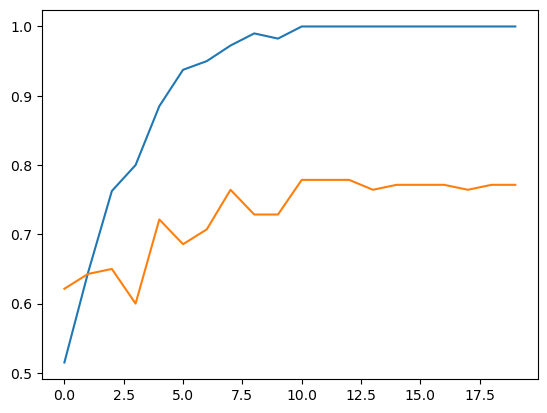

In [20]:

plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [22]:
model.evaluate(X_test, Y_test)

45/45 [==============================] - 0s 4ms/step - loss: 1.4124 - accuracy: 0.7922


[1.412404179573059, 0.7921623587608337]

In [21]:
model_test.evaluate(X_test, Y_test)

45/45 [==============================] - 0s 6ms/step - loss: 1.0183 - accuracy: 0.7012


[1.0183262825012207, 0.7011896371841431]

In [25]:
model_test.predict(X_test)

array([[7.3691271e-02, 3.1950426e-01, 2.8066280e-01, ..., 5.7849467e-02,
        1.3051696e-01, 6.3374969e-03],
       [8.4849010e-04, 2.0961245e-03, 7.4291532e-04, ..., 4.2996434e-03,
        1.5243342e-03, 9.8800606e-01],
       [4.2195656e-04, 1.1944813e-04, 9.6162606e-04, ..., 1.1239087e-02,
        1.6771106e-03, 3.1697853e-03],
       ...,
       [3.3352375e-02, 1.2827846e-01, 1.1135635e-02, ..., 3.5861641e-02,
        2.0176653e-02, 7.5501120e-01],
       [4.3657776e-02, 7.9792542e-03, 3.6163259e-02, ..., 2.5918585e-01,
        2.6142278e-01, 4.8905341e-03],
       [8.1802227e-02, 1.9727415e-01, 1.1602374e-01, ..., 1.1856729e-01,
        9.5021650e-02, 1.2227939e-01]], dtype=float32)

In [26]:
# Assigns the most likely class for each image

y_pred = np.argmax(model_test.predict(X_test), axis=-1)

In [27]:
print(test_gen.class_indices)
y_pred[:]

{'acantocyte': 0, 'elliptocyte': 1, 'hypochromic': 2, 'normal': 3, 'pencil': 4, 'spero_bulat': 5, 'stomatocyte': 6, 'targetsel': 7, 'teardrop': 8}


array([1, 8, 3, ..., 8, 3, 3], dtype=int64)

In [28]:
# The smae procedure for the 'actual' data

Y_test_multilabel = np.argmax(Y_test, axis=-1)

In [29]:
Y_test_multilabel[:]

array([1, 8, 3, ..., 8, 7, 8], dtype=int64)

In [30]:
#model_confusion_matrix = multilabel_confusion_matrix(Y_test_multilabel, y_pred)
model_confusion_matrix = confusion_matrix(Y_test_multilabel, y_pred)

In [31]:
model_confusion_matrix

array([[ 15,   3,   0,  40,   0,   0,  10,   3,   1],
       [  1, 185,   5,  21,   0,   0,   2,  14,  15],
       [  0,   1,   0,  29,   0,   0,   1,  12,   2],
       [  2,   0,   0, 261,   0,   0,   2,  21,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   6],
       [  1,   0,   0,  32,   0,  26,  18,  35,   1],
       [  0,   0,   0,  68,   0,   0,   4,   4,   1],
       [  0,   2,   1,  57,   0,   0,   4, 107,   0],
       [  0,   5,   0,   7,   0,   0,   0,   0, 404]], dtype=int64)

Text(95.72222222222221, 0.5, 'Actual')

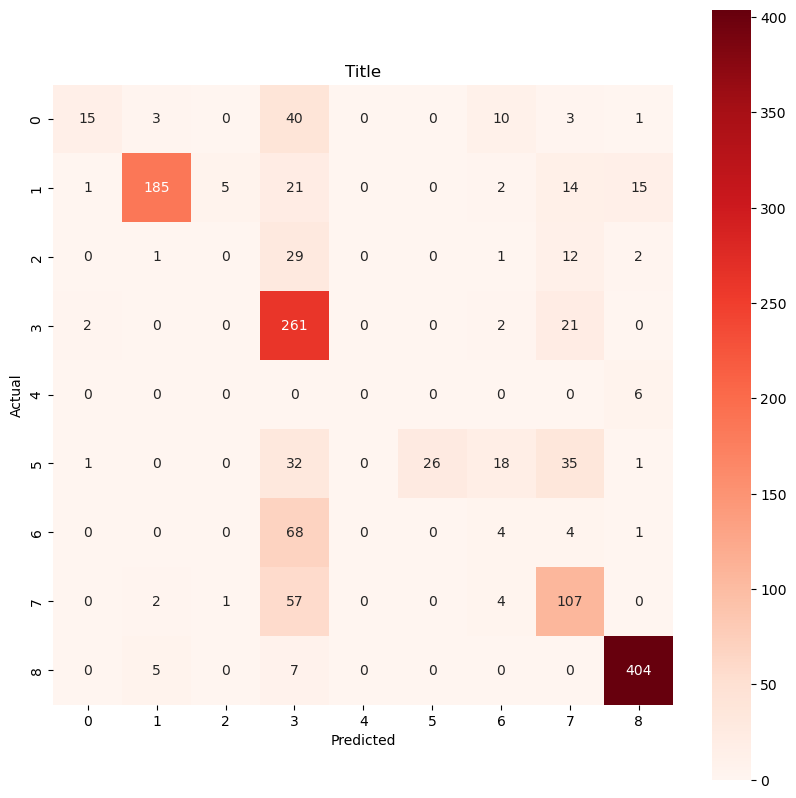

In [32]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(model_confusion_matrix, cmap='Reds', annot=True, square=True, fmt='d')
plt.title("Title")    
plt.xlabel('Predicted')
plt.ylabel('Actual')

The model actually does realatively good job on recognizing most cell shapes other than normal